In [1]:
#@title

# Basic
import numpy as np
import pandas as pd

# Plotation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# ML Models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Miscellaneous
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix_and_roc_curves(model, X_test, y_test, y_pred):

    pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, pred_proba, pos_label=1)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))  # Set the figure size as needed
    plt.plot(fpr, tpr, linestyle='--', color='red', label=f'{type(model).__name__} (AUC = {roc_auc_score(y_test, pred_proba):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='-', color='blue')  # This is the line for random chance

    # Adding labels and title
    plt.title('ROC Curve', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})

    # Adding a legend
    plt.legend(loc='best')
    plt.show()

In [3]:
def visualization(results_df, parameters):    

    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    column_results = [f"param_{name}" for name in parameters.keys()]
    column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

    results_df = results_df[column_results].sort_values("mean_test_score", ascending=False)
    results_df = results_df.rename(shorten_param, axis=1)

    for col in results_df.columns:
        if col == 'param_random_state':
            continue
        try:
            results_df[col] = results_df[col].astype(np.float64)
        except:
            continue

    fig = px.parallel_coordinates(
    results_df,
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Hyper Parameter Tuning',)
    fig.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from imblearn.metrics import geometric_mean_score


def evaluation_metrics(name, independent_feature_length , y_pred, y_test):

    # Load your datasets
    train_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\smote_balanced_dataset.csv')
    test_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\aug_test_processed.csv')
    answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Raw\\answer.npy')

    # Separate features and target
    X_train_full = train_data.drop('Response', axis=1)
    y_train_full = train_data['Response']
    X_test = test_data.drop('id', axis=1)  # Assuming 'id' column is not needed for prediction

    # Initialize the scaler
    scaler = MinMaxScaler()

    # List of numerical columns to scale
    columns_to_scale = ['Policy_Sales_Channel', 'Vintage', 'Annual_Premium_Treated']

    # Scaling only the specified columns in the training data
    X_train_scaled = X_train_full.copy()  # Create a copy to avoid changing the original data
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_full[columns_to_scale])

    # Scaling only the specified columns in the test data using the same scaler
    X_test_scaled = X_test.copy()  # Create a copy to avoid changing the original data
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


    # Split the train data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.2, random_state=42)

    # Initialize and train the classifier with class weights to handle imbalance
    classifier = RandomForestClassifier(
        class_weight={0: 1, 1: 330},  # Adjust weights as needed
        random_state=34, max_depth=2, criterion='entropy'
    )
    classifier.fit(X_train, y_train)
    # Predict probabilities for the validation and test sets
    y_val_probs = classifier.predict_proba(X_val)[:, 1]
    y_test_probs = classifier.predict_proba(X_test_scaled)[:, 1]

    # Determine the best threshold for precision
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)
    target_recall = 0.80  # Define target recall level
    valid_indices = np.where(recall >= target_recall)[0]  # Indices where recall is above target

    best_threshold = thresholds[valid_indices[np.argmax(precision[valid_indices])] if valid_indices.size > 0 else 0]

    # Apply threshold to validation and test set predictions
    y_val_pred = (y_val_probs >= best_threshold).astype(int)
    y_test_pred = (y_test_probs >= best_threshold).astype(int)
    
    # Evaluate the model
    
    metrics_dict = {}
    metrics_dict['Accuracy_Score'] = [balanced_accuracy_score(answers, y_test_pred)]  #Accuracy Score
    metrics_dict['Recall'] = [recall_score(answers, y_test_pred)] #Recall
    metrics_dict['Geomean'] = [geometric_mean_score(answers, y_test_pred)]
    metrics_dict['F1_Score'] = [f1_score(answers, y_test_pred, average='weighted')] #F1 Score
    metrics_dict['ROC_AUC_Score'] = [roc_auc_score(answers, y_test_pred)] #ROC AUC Score
    metrics_dict['Log_Loss'] = [log_loss(answers, y_test_pred)] #Log Loss
     

    metrics_df = pd.DataFrame(metrics_dict)
    
    print(metrics_df)
   

In [5]:
from sklearn.metrics import precision_recall_curve

def evaluate_and_visualize(y_test, y_probs, model, X_test):
    # Determine the best threshold for precision-recall trade-off
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # Assuming you want a recall of at least 80%
    target_recall = 0.80  
    valid_indices = np.where(recall >= target_recall)[0]
    best_threshold = thresholds[valid_indices[np.argmax(precision[valid_indices])] if valid_indices.size > 0 else 0]
    print(f"Best threshold: {best_threshold}")

    # Apply threshold to get final predictions
    y_pred = (y_probs >= best_threshold).astype(int)

    # Calculate metrics
    metrics_dict = {
        'Accuracy_Score': balanced_accuracy_score(y_test, y_pred),
        'Gmean': geometric_mean_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred, average='weighted'
                             ),
        'ROC_AUC_Score': roc_auc_score(y_test, y_probs),
        'Log_Loss': log_loss(y_test, y_pred),
     
    }

    metrics_df = pd.DataFrame([metrics_dict])
    print(metrics_df)
    plot_confusion_matrix_and_roc_curves(model, X_test, y_test, y_pred)

def hyperparameter_tuning(X_train, y_train, X_val, y_val, model, parameters, tuning_model):
    if tuning_model == 'Halving_Randomized_Search_CV':
        tuned_model = HalvingRandomSearchCV(model, param_distributions=parameters, scoring="accuracy", n_jobs=-1, factor=3, cv=5)
    elif tuning_model == 'Randomized_Search_CV':
        tuned_model = RandomizedSearchCV(model, param_distributions=parameters, scoring='accuracy', cv=3, n_iter=50, n_jobs=-1)
    else:
        tuned_model = GridSearchCV(model, param_grid=parameters, scoring='accuracy', n_jobs=-1, cv=3)

    tuned_model.fit(X_train, y_train)
    # Evaluate on validation set using probabilities and dynamic thresholding
    y_val_probs = tuned_model.predict_proba(X_val)[:, 1]
    evaluate_and_visualize(y_val, y_val_probs, tuned_model.best_estimator_, X_val)

    return tuned_model

# Example call to the function
# hyperparameter_tuning(X_train, y_train, X_val, y_val, RandomForestClassifier(), parameters, 'Randomized_Search_CV')


In [6]:
from sklearn.ensemble import RandomForestClassifier


def perform_ml_algorithm(x_train, x_test, y_train, y_test, model, parameters, tuning_model):
    print('-----'*10+f'\n{type(model).__name__}\n'+'-----'*10)

    # Load your datasets
    train_data =  pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\smote_balanced_dataset.csv')
    test_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\aug_test_processed.csv')
    answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Raw\\answer.npy')

    # Separate features and target
    X_train_full = train_data.drop('Response', axis=1)
    y_train_full = train_data['Response']
    X_test = test_data.drop('id', axis=1)  # Assuming 'id' column is not needed for prediction

    # Initialize the scaler
    scaler = MinMaxScaler()

    # List of numerical columns to scale
    columns_to_scale = ['Policy_Sales_Channel', 'Vintage', 'Annual_Premium_Treated']

    # Scaling only the specified columns in the training data
    X_train_scaled = X_train_full.copy()  # Create a copy to avoid changing the original data
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_full[columns_to_scale])

    # Scaling only the specified columns in the test data using the same scaler
    X_test_scaled = X_test.copy()  # Create a copy to avoid changing the original data
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


    # Split the train data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.2, random_state=42)

    # Initialize and train the classifier with class weights to handle imbalance
    classifier = RandomForestClassifier(
        class_weight={0: 1, 1: 330},  # Adjust weights as needed
        random_state=34, max_depth=2, criterion='entropy'
    )
    classifier.fit(X_train, y_train)
    #model.fit(x_train, y_train)
    untuned_pred = classifier.predict(X_test_scaled)

    # Evaluation Metrics before tuning
    print(f'\nEvaluation of {type(model).__name__} before tuning:\n'+'-----'*10)
    evaluation_metrics(type(model).__name__, len(list(x_train.columns)), untuned_pred, y_test)

    print()
    plot_confusion_matrix_and_roc_curves(classifier, X_test_scaled , answers, untuned_pred)

    # Hyper-parameter tuning
    #tuned_model = hyperparameter_tuning(X_train, y_train, X_test_scaled, answers , model, parameters, tuning_model)


In [7]:
def ml_algorithm_implementation(df, model, parameters, tuning_model, feature_importance = False):

    if feature_importance == False:
        print('########'*8+'\n     <<<< '+f'Tuning Model: {tuning_model}'+' >>>>\n'+'********'*8)

    # Load your datasets
    train_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\smote_balanced_dataset.csv')
    test_data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\aug_test_processed.csv')
    answers = np.load('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Raw\\answer.npy')

    # Separate features and target
    X_train_full = train_data.drop('Response', axis=1)
    y_train_full = train_data['Response']
    X_test = test_data.drop('id', axis=1)  # Assuming 'id' column is not needed for prediction

    # Initialize the scaler
    scaler = MinMaxScaler()

    # List of numerical columns to scale
    columns_to_scale = ['Policy_Sales_Channel', 'Vintage', 'Annual_Premium_Treated']

    # Scaling only the specified columns in the training data
    X_train_scaled = X_train_full.copy()  # Create a copy to avoid changing the original data
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_full[columns_to_scale])

    # Scaling only the specified columns in the test data using the same scaler
    X_test_scaled = X_test.copy()  # Create a copy to avoid changing the original data
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Split the train data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.2, random_state=42)
    if feature_importance == True:
        model.fit(X_train, y_train)
        return X_train, y_train, model

    perform_ml_algorithm(X_train, y_train, X_test_scaled, answers, model, parameters, tuning_model)
    

In [8]:
#@title Keep it Halving_Randomized_Search_CV!! Other methods are time consuming.
Tuning_Method = "Halving_Randomized_Search_CV" #@param ["Halving_Randomized_Search_CV", "Grid_Search_CV", "Randomized_Search_CV"]

################################################################
     <<<< Tuning Model: Halving_Randomized_Search_CV >>>>
****************************************************************
--------------------------------------------------
RandomForestClassifier
--------------------------------------------------

Evaluation of RandomForestClassifier before tuning:
--------------------------------------------------
   Accuracy_Score    Recall   Geomean  F1_Score  ROC_AUC_Score  Log_Loss
0        0.793759  0.819005  0.793357  0.801882       0.793759  8.045619



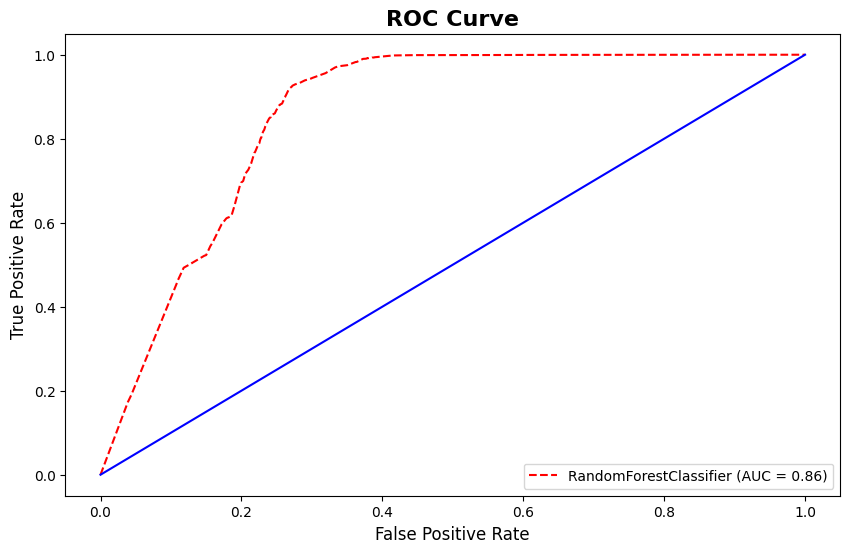

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameters for Random Forest
parameters_random_forest = {
    "n_estimators": [100, 150, 200],
    "max_depth": [2, 4, 6, 8],  # Expanded range for max_depth
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "min_weight_fraction_leaf": [0.0, 0.1, 0.2],  # Adjusted values
    "max_features": ["sqrt", "log2", None],  # Removed 'auto'
    "max_leaf_nodes": [None, 50, 100],  # Adjusted values
    'random_state': [34],  
    'class_weight': [{0: 1, 1: 330}]  
}



data = pd.read_csv('C:\\Users\\USER-PC\\Desktop\\ThesisCode\\Data\\Preprocessed\\smote_balanced_dataset.csv')
# Call your function for RandomForestClassifier
ml_algorithm_implementation(data, RandomForestClassifier(), parameters_random_forest, Tuning_Method, False)
